In [1]:
%%html
<!-- left align tables -->
<style>
table {margin-left: 0 !important;}
</style>

# Identify Persons of Interest in the Enron Corpus Dataset

## Introduction


## Data Exploration

### Dataset Description

email
https://www.cs.cmu.edu/~./enron/

finance
http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf

In [2]:
# import packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from helper_functions import convert_dict_to_df, scatter_plot, print_score_table, best_parameter_search

In [3]:
# load dictionary containing the dataset
with open("enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# feature list
features = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 
            'director_fees', 'exercised_stock_options', 'expenses', 
            'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
            'restricted_stock_deferred', 'salary', 'total_payments', 
            'total_stock_value', 'email_address', 'from_messages', 
            'from_poi_to_this_person', 'from_this_person_to_poi', 
            'shared_receipt_with_poi', 'to_messages']

# convert specified features to data frame
data_df = convert_dict_to_df(data_dict, features, remove_NaN=False, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=True)

print(data_df.shape)
print(len(list(data_df.columns.values)))
print(data_df['poi'].sum())

(146, 22)
22
18


The underlying dataset for this project is a combination of Enron email and financial data. The data is present in the `enron_dataset.pkl` file where it is stored in a dictionary structure. Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

The data contains three major feature categories: POI labels, financial features and email features. The 21 feature names and their type are described in the table below.

| Feature                   | Type        |
|-------------------------- | ----------- |
| poi                       | categorical |
| bonus                     | numerical   |
| deferral_payments         | numerical   |
| deferred_income           | numerical   |
| director_fees             | numerical   |
| exercised_stock_options   | numerical   |
| expenses                  | numerical   |
| loan_advances             | numerical   |
| long_term_incentive       | numerical   |
| other                     | numerical   |
| restricted_stock          | numerical   |
| restricted_stock_deferred | numerical   |
| salary                    | numerical   |
| total_payments            | numerical   |
| total_stock_value         | numerical   |
| email_address             | text        |
| from_messages             | numerical   |
| from_poi_to_this_person   | numerical   |
| from_this_person_to_poi   | numerical   |
| shared_receipt_with_poi   | numerical   |
| to_messages               | numerical   |

The dataset contains information about 146 different data points. Of those, 18 are marked as POI.

Missing values...

In [4]:
# count number of NaN values in each column
print("Number of NaN values in each columns:")
print("-------------------------------------")
print(data_df.isnull().sum())

Number of NaN values in each columns:
-------------------------------------
name                           0
poi                            0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
other                         53
restricted_stock              36
restricted_stock_deferred    128
salary                        51
total_payments                21
total_stock_value             20
email_address                 35
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
to_messages                   60
dtype: int64


The dataset contains a lot of features with missing values. One can see that it is based on the finacial data and that only for 86 point a connection to the email dataset could be made (60 data points without email data). For the features 'deferral_payments', 'director_fees', 'loan_advances' and 'restricted_stock_deferred' the fewest amount of  data is available.

### Outliers

In the financial data a strange outlier was found. This data point had the largest values for all the different financial feature and was identified as the total column from the spreadsheet. Futhermore, I discovered the key 'THE TRAVEL AGENCY IN THE PARK' which is not the name of a person as well as the data point of 'LOCKHART EUGENE E' that consists of all zero values. These lines were dropped and not considered further.

In [5]:
# drop outlier rows
for n in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']:
    data_df = data_df[data_df['name'] != n]

print(data_df.shape)

(143, 22)


log scaling of skewed distributions???

### Feature Engineering

Before selecting the features that influence 'poi' labelling the most I created two new features. First of all, I thought about looking at the ratio between 'restricted_stock' and 'total_stock_value'. As POIs in general had higher stock options maybe they also tried to prevent those from being restricted leading to low values for the 'poi_email_fraction'. Secondly, I created a new variable comparing the number of emails received from and sent to POIs with the total number of email received and sent by each pearson. I would expect POIs to communicate more frequently with other POIs and thus having higher 'poi_email_fraction' values.

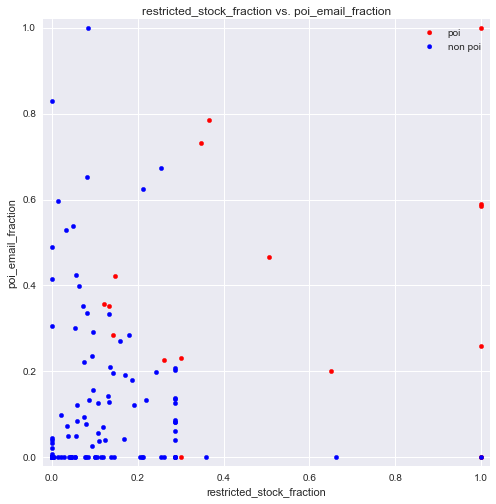

In [6]:
# poi fraction
data_df['restricted_stock_fraction'] = data_df['restricted_stock'] / data_df['total_stock_value']
data_df['poi_email_fraction'] = (data_df['from_poi_to_this_person'] + data_df['from_this_person_to_poi']) / (data_df['from_messages'] + data_df['to_messages'])

# visualization
scatter_plot(data_df, 'restricted_stock_fraction', 'poi_email_fraction')

By visualizing these new featuers one can see that all but one POI have a 'poi_email_fraction' larger than 0.2. The point that breaks ranks occurs as there is no email data for that person available. Most POIs have 'restricted_stock_fractions' between 0.2 and 0.7 but there are three data points that have all their stocks restircted.

### Feature Selection



SelectKBest

scales features for meaningful comparison

In [7]:
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi']

selector = SelectKBest(k=X.shape[1])
selector.fit(X, y)

features = X[selector.get_support(indices=True)].columns.values
scores = selector.scores_
score_list = sorted([(f, s) for f, s in zip(features, scores)], key=lambda tup: tup[1], reverse=True)

print("{:<25} {:<10}".format("Feature", "Score"))
print("-------------------------------")
for tup in score_list:
    print("{:<25} {}".format(tup[0], round(tup[1], 2)))

Feature                   Score     
-------------------------------
exercised_stock_options   24.82
total_stock_value         24.18
bonus                     20.79
salary                    18.29
deferred_income           11.46
long_term_incentive       9.92
restricted_stock          9.21
total_payments            8.77
shared_receipt_with_poi   8.59
loan_advances             7.18
expenses                  6.09
poi_email_fraction        5.4
from_poi_to_this_person   5.24
other                     4.19
from_this_person_to_poi   2.38
director_fees             2.13
to_messages               1.65
restricted_stock_fraction 1.09
deferral_payments         0.22
from_messages             0.17
restricted_stock_deferred 0.07


For the rest of project we will focus on the ten features with the highest scores. Nine of these come from the financial data and only 'shared_receipt_with_poi' comes from the emails. Below, one can see the top five features visualized in a scatter matrix.

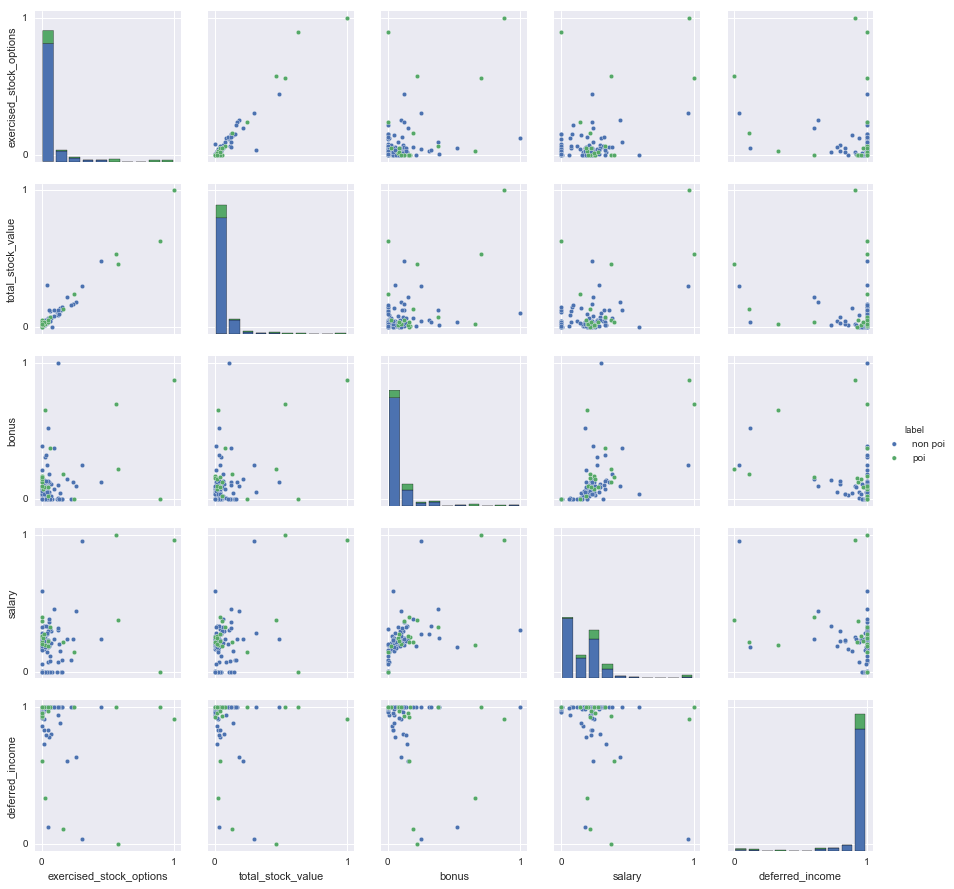

In [8]:
# create scatter matrix of the top 5 features
top_5_features = [f for (f, s) in list(score_list)[:5]]

# add 'poi' to include this feature in the plotting dataframe
plot_features = top_5_features
plot_features.append('poi')

# create dataframe copy with the desired columns for plotting
data_df_plot = data_df.loc[:, plot_features].fillna(value=0)

# scale all features except for 'poi'
scaler = MinMaxScaler()
data_df_plot[top_5_features[:-1]] = scaler.fit_transform(data_df_plot[top_5_features[:-1]])

# create 'label' feature as 'hue' input for sns.pairplot() 
data_df_plot['label'] = 0
data_df_plot.loc[data_df_plot['poi'] == True, 'label'] = 'poi'
data_df_plot.loc[data_df_plot['poi'] == False, 'label'] = 'non poi'

# remove 'poi' feature
data_df_plot.drop(['poi'], axis=1, inplace=True)

# create pairplot
fig = sns.pairplot(data_df_plot, hue="label", diag_kind="hist")  

# format axes
for i, axes in enumerate(fig.axes):
    for j, ax in enumerate(axes):
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.set_xticklabels([0, 1])
        ax.set_xticks([0, 1])
        ax.set_yticklabels([0, 1])
        ax.set_yticks([0, 1])

plt.show()

interpretation scatter matrix


only use 'exercised_stock_options' or 'total_stock_value', strong correlation between these two features as expected

deferred_income is negative -> most values around 1

'loan_advances' contains only 3 non zero values 


replacement with 'expenses' and 'poi_email_fraction'

In [9]:
# store top 10 features in a list
top_10_features = [f for (f, s) in list(score_list)[:10]]
top_10_features.extend(['expenses', 'poi_email_fraction'])
top_10_features = [i for i in top_10_features if i not in ['total_stock_value', 'loan_advances']]

## Algorithm Selection


Random Forest Classifer, Support Vector Machine & Logistic Regression

`StratifiedShuffleSplit` because data is imbalanced and sensitive to input so we use kfold crossvalidation

still very  sensitive results, vary strongly each run




In [10]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))
X = X.values

y = data_df['poi'].astype(int).values

# classifier names and objects    
names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Classifier', 'KNeighbors Classifier', 
         'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
classifiers =[LogisticRegression(random_state=42),
              GaussianNB(),
              SVC(random_state=42),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42)]

print_score_table(names, classifiers, X, y, random_state=42)

Classifier                Accuracy   Precision  Recall
------------------------------------------------------
Logistic Regression       0.87       0.22       0.05
Gaussian Naive Bayes      0.84       0.38       0.34
Support Vector Classifier 0.88       0.0        0.0
KNeighbors Classifier     0.86       0.11       0.03
Decision Tree Classifier  0.81       0.28       0.3
Random Forest Classifier  0.87       0.29       0.12
AdaBoost Classifier       0.84       0.3        0.23


three different metrics, accuracy is generally high because of the imbalace in the data und thus all models predict a large amount of non-POI correctly. Precision... . Recall... .
warning because classifier predicted no POI in the test set correctly

vary number of input features, from 1 to 10 based on feature selection ranking

'Stratified

In [11]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int)

# dictionary to store all results
clf_results = {} 
for n in names:
    clf_results[n] = {}
    for i in range(1, len(top_10_features) + 1):
        clf_results[n][i] = {'accuracy': [], 'precision': [], 'recall': []}

# loop trough features
for i in range(1, len(top_10_features) + 1):
    features = top_10_features[:i]
    X_i = X.loc[:, features]
    
    # training and test set split
    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.33, random_state=42)
    for train_ixs, test_ixs in sss.split(X_i, y):
        X_i_train, X_i_test = X_i.iloc[train_ixs].values, X_i.iloc[test_ixs].values
        y_train, y_test = y.iloc[train_ixs].values, y.iloc[test_ixs].values

        for n, clf in zip(names, classifiers):
            clf.fit(X_i_train, y_train)
            pred = clf.predict(X_i_test)
            
            accuracy = clf.score(X_i_test, y_test)
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            
            clf_results[n][i]['accuracy'].append(accuracy)
            clf_results[n][i]['precision'].append(precision)
            clf_results[n][i]['recall'].append(recall)

# reformat results dictionary for easier plotting
clf_results_plot = {}
for n in names:
    clf_results_plot[n] = {"accuracy": [], 'precision': [], 'recall': []}
    
    for i in range(1, len(top_10_features) + 1):
        accuracy_cv = np.mean(clf_results[n][i]['accuracy'])
        precision_cv = np.mean(clf_results[n][i]['precision'])
        recall_cv = np.mean(clf_results[n][i]['recall'])
        
        clf_results_plot[n]['accuracy'].append(accuracy_cv)
        clf_results_plot[n]['precision'].append(precision_cv)
        clf_results_plot[n]['recall'].append(recall_cv)

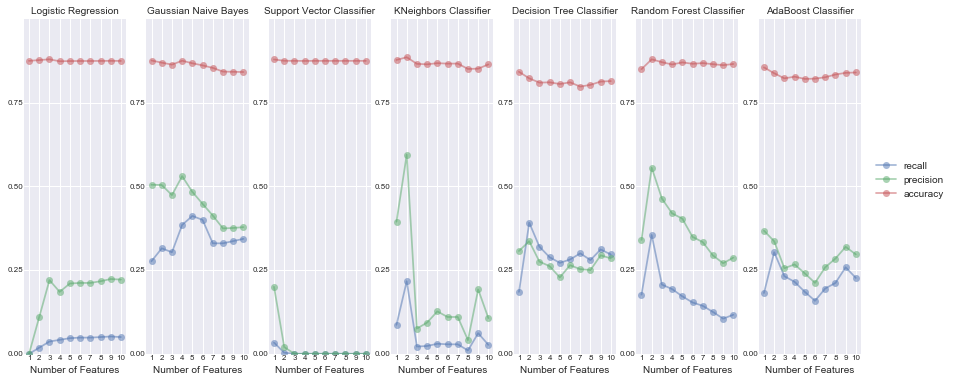

In [12]:
# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(names), figsize=(15, 6))
n_features = np.arange(1, len(top_10_features) + 1)

for ax, title in zip(axs, names):
    for m in clf_results_plot[title].keys():
        ax.plot(n_features, clf_results_plot[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0], yticks=np.arange(0, 1, 0.25))
        ax.set_xlabel("Number of Features", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)

plt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))
plt.show()

consolidate two qualifier metrics from results above

GaussianNB, Decision Tree, Random Forest and AdaBoost seem to perform the best, focus on these four for the remaining analysis, no major influence of feature number on performance visible, stick with top 10

next step

GridSeachCV for parameter optimization

GaussianNB: -


Decision Tree: criterion -> 'gini', 'entropy', min_samples_split -> 2, 5, 10


Random Forest: n_estimators -> 5, 10, 15, 20, criterion -> 'gini', 'entropy', min_samples_split -> 2, 5, 10


AdaBoost: n_estimators -> 20, 50, 100


In [13]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))
X = X.values

y = data_df['poi'].astype(int).values
        
# parameter tuning
param_grid = {'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              'Gaussian Naive Bayes': {}, # GaussianNB has no parameters
              'Support Vector Classifier': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
              'KNeighbors Classifier': {'n_neighbors': [1, 2, 5, 10, 20],
                                        'algorithm': ['ball_tree', 'kd_tree', 'brute']},
              'Decision Tree Classifier': {'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'Random Forest Classifier': {'n_estimators': [1, 2, 5, 10, 20], 
                                           'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'AdaBoost Classifier': {'n_estimators': [1, 2, 5, 10, 20]}}

best_parameter_search(names, classifiers, X, y, param_grid, score='precision', random_state=42)
print()
best_parameter_search(names, classifiers, X, y, param_grid, score='recall', random_state=42)

Classifier                Precision  Parameters
------------------------------------------------
Logistic Regression       0.35       {'C': 10}
Gaussian Naive Bayes      0.38       {}
Support Vector Classifier 0.24       {'C': 100}
KNeighbors Classifier     0.31       {'algorithm': 'ball_tree', 'n_neighbors': 1}
Decision Tree Classifier  0.3        {'min_samples_split': 5, 'criterion': 'gini'}
Random Forest Classifier  0.36       {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 20}
AdaBoost Classifier       0.34       {'n_estimators': 2}

Classifier                Recall     Parameters
------------------------------------------------
Logistic Regression       0.15       {'C': 1000}
Gaussian Naive Bayes      0.34       {}
Support Vector Classifier 0.09       {'C': 1000}
KNeighbors Classifier     0.26       {'algorithm': 'ball_tree', 'n_neighbors': 1}
Decision Tree Classifier  0.3        {'min_samples_split': 2, 'criterion': 'gini'}
Random Forest Classifier  0.27       {'min

select best algorithms based on results above

tune parameters and number of features together for best algorithms
-> probably different best number of features for each algorithm

cross-validation for train/test split -> stratifiedkfold

In [19]:
# selection of best classifiers
top_ixs = [1, 4, 5, 6]
names_top = [n for i, n in enumerate(names) if i in top_ixs]
classifiers_top = [clf for i, clf in enumerate(classifiers) if i in top_ixs]

param_grid_top = {k: v for k, v in param_grid.items() if k not in ['Logistic Regression', 'Support Vector Classifier', 
                                                                   'KNeighbors Classifier']}

# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int).values

# loop through features
for i in range(1, len(top_10_features) + 1):
    features = top_10_features[:i]
    X_i = X.loc[:, features].values
    
    print(i)
    best_parameter_search(names_top, classifiers_top, X_i, y, param_grid_top, score='precision', random_state=42)
    print()
    best_parameter_search(names_top, classifiers_top, X_i, y, param_grid_top, score='recall', random_state=42)

1
Classifier                Precision  Parameters
------------------------------------------------
Gaussian Naive Bayes      0.5        {}
Decision Tree Classifier  0.4        {'min_samples_split': 20, 'criterion': 'gini'}
Random Forest Classifier  0.57       {'min_samples_split': 20, 'criterion': 'gini', 'n_estimators': 20}
AdaBoost Classifier       0.59       {'n_estimators': 1}

Classifier                Recall     Parameters
------------------------------------------------
Gaussian Naive Bayes      0.28       {}
Decision Tree Classifier  0.19       {'min_samples_split': 10, 'criterion': 'gini'}
Random Forest Classifier  0.2        {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 10}
AdaBoost Classifier       0.19       {'n_estimators': 1}
2
Classifier                Precision  Parameters
------------------------------------------------
Gaussian Naive Bayes      0.5        {}
Decision Tree Classifier  0.36       {'min_samples_split': 5, 'criterion': 'entropy'}
Random Fo

In [23]:
def find_best_parameters(names, classifiers, X, y, param_grid, score='accuracy', random_state=None):
    """
    Exhaustive search over specified parameter values for passed classifiers. Prints out a table 
    displaying the results.
    
    Args:
        names:
        classifiers:
        X:
        y:
        param_grid:
        score:
        random_state:

    Returns:

    """
    clf_scores = {}

    for n, clf in zip(names, classifiers):
        clf_scores[n] = {}

        cv = StratifiedShuffleSplit(n_splits=100, test_size=0.33, random_state=random_state)
        clf = GridSearchCV(clf, param_grid[n], cv=cv, scoring=score) #'{}_macro'.format(
        clf.fit(X, y)
        
        clf_scores[n][score] = clf.best_score_
        clf_scores[n]['parameters'] = clf.best_params_
    
    return clf_scores


def print_score_parameter_table():
    """
    ....
    
    Args:
    
    """
    pass
    
    

# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int).values

scores = find_best_parameters(names_top, classifiers_top, X, y, param_grid_top, score='precision', random_state=42)

print(scores)

{'AdaBoost Classifier': {'precision': 0.33832287157287161, 'parameters': {'n_estimators': 2}}, 'Gaussian Naive Bayes': {'precision': 0.37832145632145636, 'parameters': {}}, 'Decision Tree Classifier': {'precision': 0.30346572871572869, 'parameters': {'min_samples_split': 5, 'criterion': 'gini'}}, 'Random Forest Classifier': {'precision': 0.35499999999999998, 'parameters': {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 20}}}


## PCA Approach

Instead of selecting the features that influence target labels the most one can use principal component analysis (PCA) to condense all...

In [14]:
# data preparation
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi'].astype(int).values

# pca
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.values)

print_score_table(names, classifiers, X_pca, y, random_state=42)

Classifier                Accuracy   Precision  Recall
------------------------------------------------------
Logistic Regression       0.82       0.28       0.26
Gaussian Naive Bayes      0.87       0.54       0.26
Support Vector Classifier 0.88       0.0        0.0
KNeighbors Classifier     0.86       0.29       0.08
Decision Tree Classifier  0.8        0.23       0.25
Random Forest Classifier  0.84       0.2        0.09
AdaBoost Classifier       0.82       0.24       0.22


In [15]:
# parameter tuning
best_parameter_search(names, classifiers, X, y, param_grid, score='precision', random_state=42)
print()
best_parameter_search(names, classifiers, X, y, param_grid, score='recall', random_state=42)

Classifier                Precision  Parameters
------------------------------------------------
Logistic Regression       0.18       {'C': 10}
Gaussian Naive Bayes      0.25       {}
Support Vector Classifier 0.0        {'C': 0.001}
KNeighbors Classifier     0.35       {'algorithm': 'ball_tree', 'n_neighbors': 5}
Decision Tree Classifier  0.27       {'min_samples_split': 5, 'criterion': 'gini'}
Random Forest Classifier  0.32       {'min_samples_split': 2, 'criterion': 'gini', 'n_estimators': 5}
AdaBoost Classifier       0.34       {'n_estimators': 2}

Classifier                Recall     Parameters
------------------------------------------------
Logistic Regression       0.2        {'C': 1}
Gaussian Naive Bayes      0.52       {}
Support Vector Classifier 0.0        {'C': 0.001}
KNeighbors Classifier     0.21       {'algorithm': 'ball_tree', 'n_neighbors': 1}
Decision Tree Classifier  0.26       {'min_samples_split': 2, 'criterion': 'gini'}
Random Forest Classifier  0.27       {'min_

## Conclusion

best model...
